In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

from Bio.PDB import *
import Bio.PDB as pdb

Structure exists: './data/pdb/pdb1a11.ent' 
Structure exists: './data/pdb/pdb1acw.ent' 
Structure exists: './data/pdb/pdb1adx.ent' 
Structure exists: './data/pdb/pdb1ag7.ent' 
Structure exists: './data/pdb/pdb1aie.ent' 
Structure exists: './data/pdb/pdb1ale.ent' 
Structure exists: './data/pdb/pdb1alf.ent' 
Structure exists: './data/pdb/pdb1alg.ent' 
Structure exists: './data/pdb/pdb1amb.ent' 
Structure exists: './data/pdb/pdb1amc.ent' 


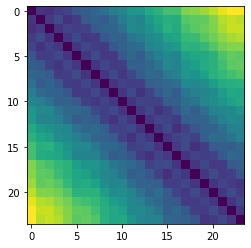

In [21]:
chars = "A   C   D   E   F   G   H   I   K   L   M   N   P   Q   R   S   T   V   W   Y".split()
s = np.array(chars).reshape(-1, 1)

def MatrixContacts(residues):
    coords = []
    S = 0
    for res in residues:
        if (res.resname == 'HOH'):
            break #continue
        else:
            if res.has_id('CB'):
                coords.append(res["CB"].get_vector())
    coords = np.array(coords)
    contacts = np.zeros((len(coords), len(coords)))
    distances = np.zeros((len(coords), len(coords)))
    for i in range(len(coords)-1):
        for j in range (i+1, len(coords)):
            if (np.linalg.norm( coords[i] - coords[j]) <= 8):
                contacts[i,j] = 1
                contacts[j,i] = 1
            distances[i,j] = np.linalg.norm( coords[i] - coords[j])
            distances[j,i] = np.linalg.norm( coords[i] - coords[j])
    return contacts, distances

pdbl = PDBList()
pdb_list = pd.read_csv('protein_set_15-45.csv')
paths = []
k=0
for i in pdb_list['pdb_name']:
    path = pdbl.retrieve_pdb_file(i, pdir='./data/pdb/',
                                      file_format="pdb")
    paths+=[path]
    k+=1
    if k==10:
        break

import Bio.PDB.PDBExceptions

parser = pdb.PDBParser()

first = True 

target_dict = {}
for path in paths:
    try:
        struct = parser.get_structure(str(path)[-8:-4],  path)
        #print(struct)
        chain = struct[0].child_list[0] #0-ая модель, 0-ая цепь
        residues = chain.child_list  
        contacts, distances = MatrixContacts(residues)
        target_dict.update({str(path)[-8:-4] : contacts})
        if first:
            plt.imshow(distances)
            first = False 
    except Bio.PDB.PDBExceptions.PDBException:
        pass

with open('features/train.fasta', 'r') as myfile:
    data = myfile.read()
    data = data.replace('\n', '')

data = data.split("$")
fastas = {}
for c in data:
    #print(c)
    if(len(c)>0):
        seq = c.split("%")
        if (seq[0].lower() in target_dict.keys()):
            fastas.update({seq[0].lower() : seq[1]})


In [14]:
with open('features/train1.pssm', 'r') as myfile:
    data = myfile.readlines()

pssm_dict = {}
for i in range(len(data)):
    string = data[i]
    if (string[0]=='>'):
        #print(string[1:5])
        ids = string[1:5].lower()
        if (True or string[1:5].lower() in target_dict.keys()):
            #print(string[1:5])
            string = data[i+1]
            pssm = []
            while(string[0]!='>'):
                string = string.replace('\n', '')
                string=string[1:]
                pssm.append(string.split())
                i+=1
                
                if (i>len(data)-1):break
                
                string=data[i]
            i-=1
            pssm_dict.update({ids : np.array(pssm,dtype=float)})
 

In [24]:
file = open('features/train.acc', 'r')
accs = file.readlines()
file = open('features/train.ss', 'r')
sss = file.readlines()
result= pd.DataFrame()
for i in range(len(accs)):
    ids = sss[i][1:5].lower()
    if (i%2!=0):
        if (ids.lower() in target_dict.keys()):
            temp = pd.DataFrame({'SS':[sss[i].replace('\n', '')], 'ACC':[accs[i].replace('\n', '')]})
            
            result = pd.concat([result, temp], ignore_index=True)
 

In [28]:
faasta_df = pd.DataFrame.from_dict(fastas, orient='index')
pssm_df= pd.DataFrame.from_dict(pssm_dict, orient='index')
result = pd.concat([faasta_df, result, pssm_df], axis=1, sort=False)

/home/kamilla/anaconda3/lib/python3.8/site-packages/pandas/core/internals/construction.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [29]:
result

,0,0
1a11,GSEKMSTAISVLLAQAVFLLLTSQR,NaN
1acw,VSCEDCPEHCSTQKAQAKCDNDKCVCEPI,NaN
1adx,QMFCNQTACPADCDPNTQASCECPEGYILDDGFICTDIDE,NaN
1ag7,ACSGRGSRCPPQCCMGLRCGRGNPQKCIGAHEDV,NaN
1aie,EYFTLQIRGRERFEMFRELNEALELKDAQAG,NaN
1ale,ALDKLKEFGNTLEDKARE,NaN
1alf,SAKMREWFSETFQKVKEKL,NaN
1alg,QGLGCDEMLQGFAVAVKMGATKAD,NaN
1amb,DAEFRHDSGYEVHHQKLVFFAEDVGSNK,NaN
1amc,DAEFRHDSGYEVHHQKLVFFAEDVGSNK,NaN
